### First Cut Model

In [1]:
import time

# Get notebook runtime
startTime = time.time()

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('../output/Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('../output/Final_Test.csv')

### Now I can use this data to train model

In [4]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [7]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [8]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 246), (1623, 246), (3787,), (1623,))

In [9]:
from collections import Counter
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


## Oversample the data using SMOTE to make it 20:80 ratio

In [10]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns

#### Use GridSearchCV to find best parameters for Logistic Regression

In [12]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [13]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9404144355218997


#### Now train with best parameters using LogisticRegression

In [14]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

In [15]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [16]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [17]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

Train AUC =  0.9438267820149556
Test AUC =  0.9494257397402411


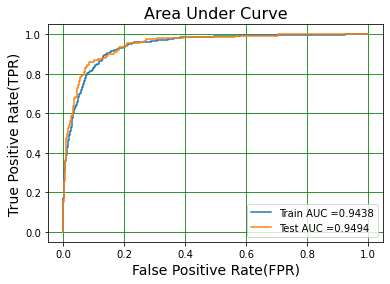

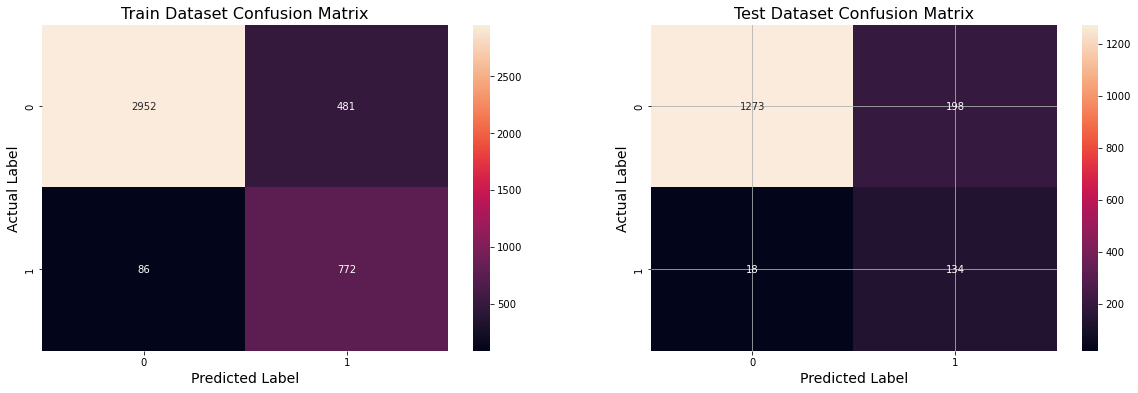

Best Threshold = 0.1291
Model AUC is : 0.9494
Model F1 Score is : 0.5537


In [18]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use GridSearchCV for DecisionTreeClassifier

In [19]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [20]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 150}
roc_auc_score : 0.930086363341923


#### Train DecisionTreeClassifier with best hyperparameters

In [21]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9553200222439955
Test AUC =  0.9367396865719704


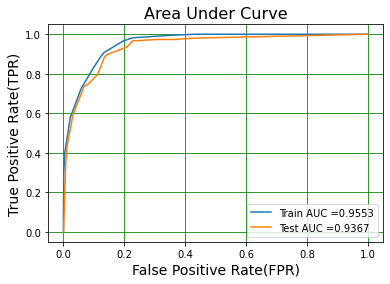

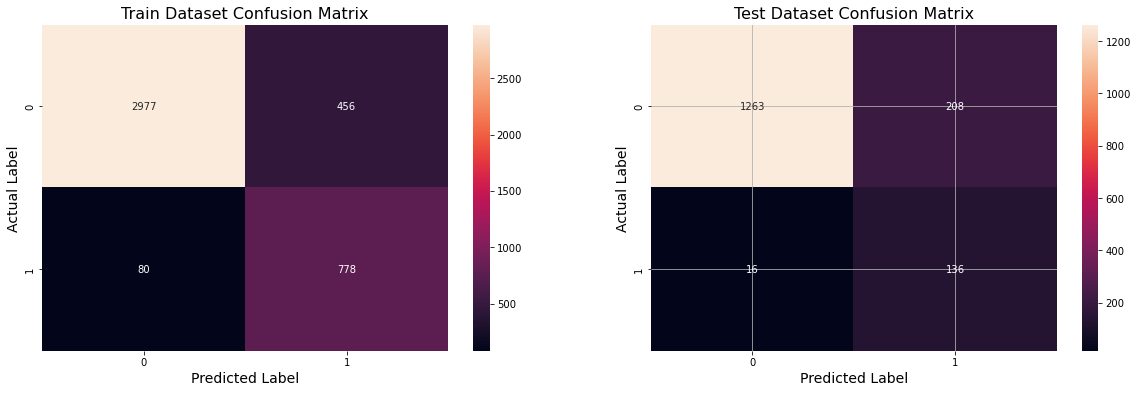

Best Threshold = 0.3261
Model AUC is : 0.9367
Model F1 Score is : 0.5484


In [22]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Use RandomSearchCV for SupportVectorClassifier

In [23]:
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py", line 1185, in _fit_libline

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [24]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.937465564347527


In [25]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.950711488724888
Test AUC =  0.9315315395899675


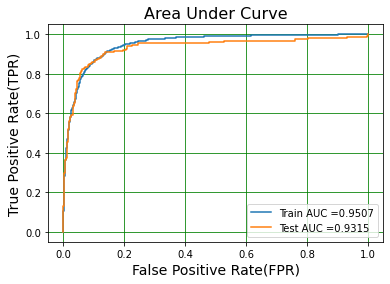

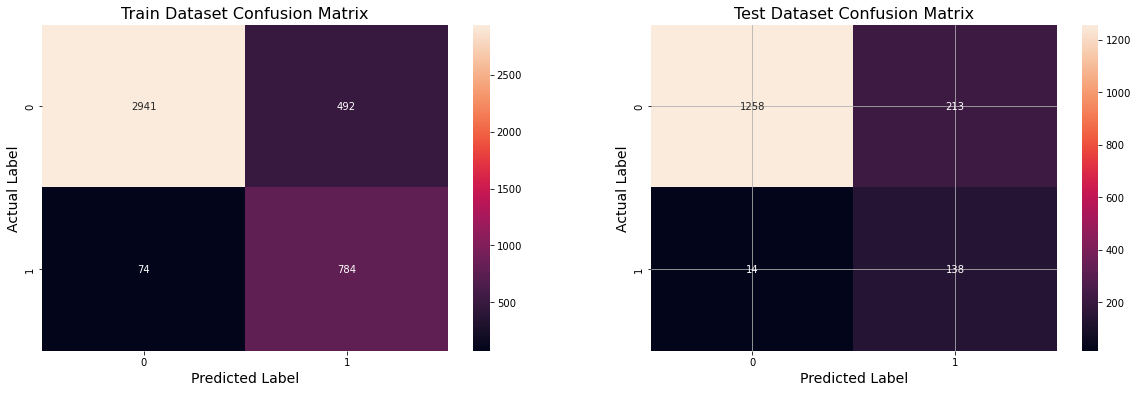

Best Threshold = 0.1394
Model AUC is : 0.9315
Model F1 Score is : 0.5487


In [26]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#### Train GaussianNB Classifier

In [27]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8451638661367762
Test AUC =  0.8793852195069591


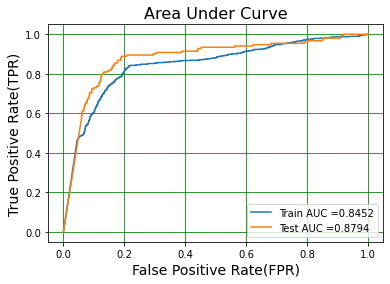

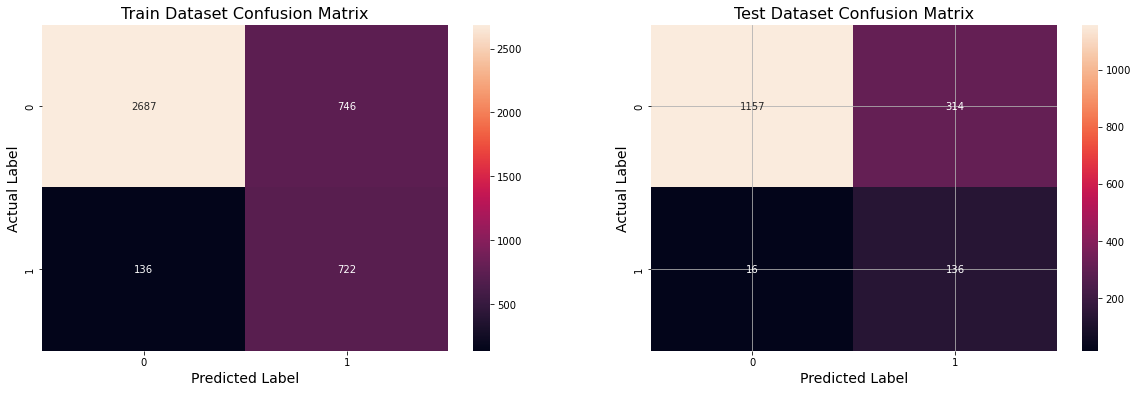

Best Threshold = 0.0000
Model AUC is : 0.8794
Model F1 Score is : 0.4518


In [28]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Observation on models for oversampling (20:80) data

In [29]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.55"])
table.append_row(["Decision Tree", "0.90", "0.53"])
table.append_row(["Support Vector Classifier", "0.94", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.46"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.55   |
+---------------------------+------+----------+
|       Decision Tree       | 0.9  |   0.53   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.46   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

## Oversample the data using SMOTE to make it 25:75 ratio

In [30]:
oversample = SMOTE(sampling_strategy=0.33)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 24.80% and Non-Fraud Percentage = 75.20%


### Train with LogisticRegression model

In [31]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

Train AUC =  0.9426757443602366
Test AUC =  0.9492244803034097


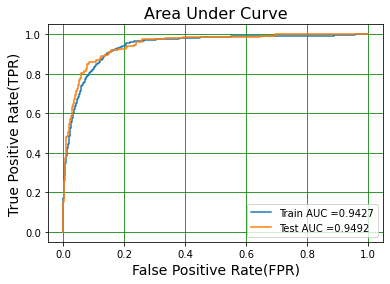

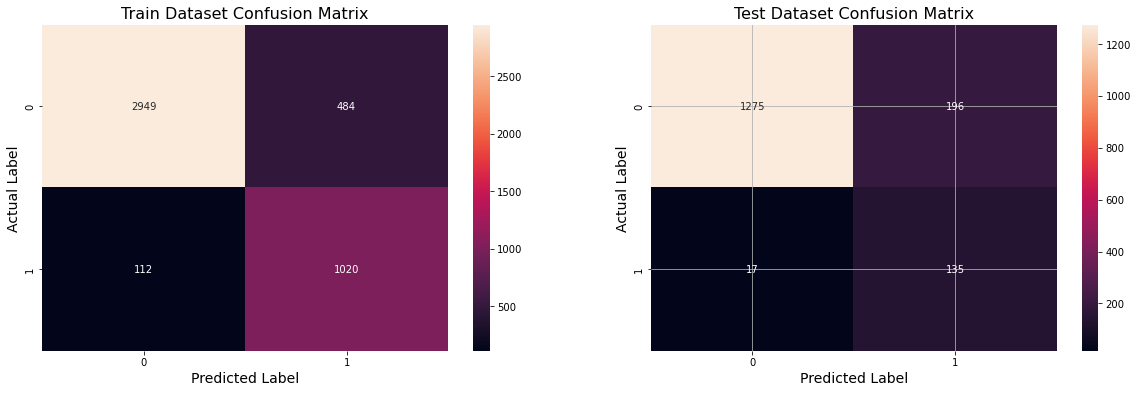

Best Threshold = 0.1552
Model AUC is : 0.9492
Model F1 Score is : 0.5590


In [32]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [33]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9560541316406238
Test AUC =  0.9291343160757094


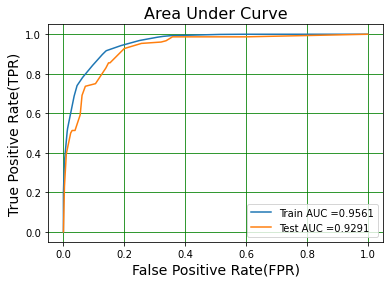

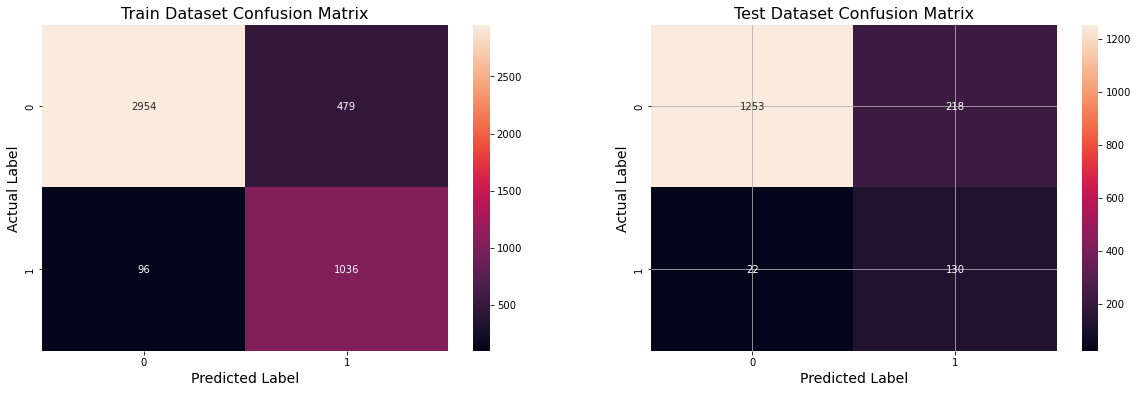

Best Threshold = 0.3333
Model AUC is : 0.9291
Model F1 Score is : 0.5200


In [34]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [35]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9512667530588066
Test AUC =  0.9437681133493149


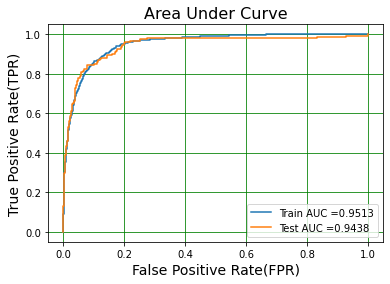

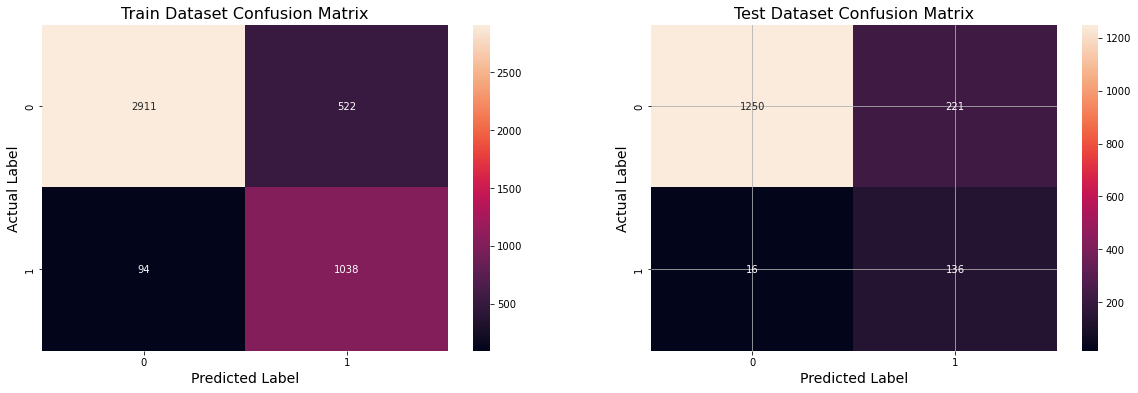

Best Threshold = 0.1694
Model AUC is : 0.9438
Model F1 Score is : 0.5344


In [36]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [37]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8397050967588537
Test AUC =  0.8795708254320369


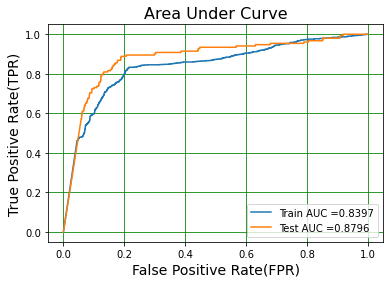

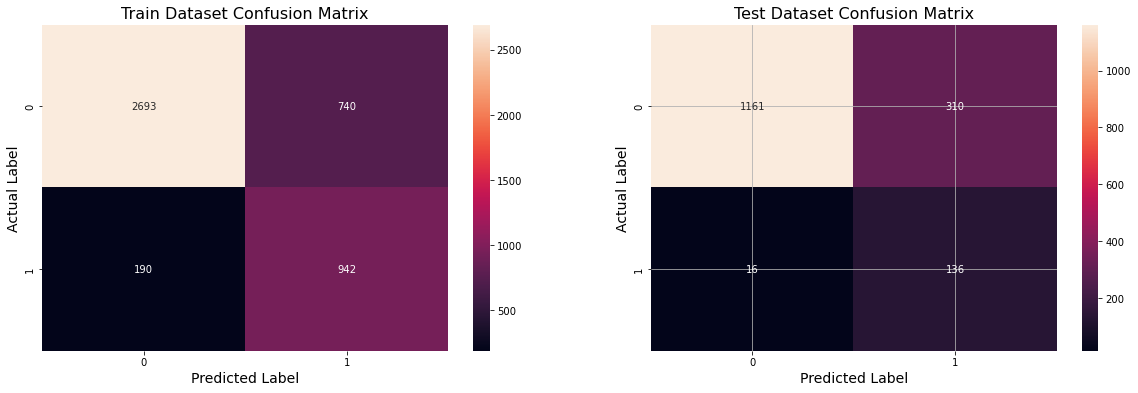

Best Threshold = 0.0000
Model AUC is : 0.8796
Model F1 Score is : 0.4548


In [38]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [39]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.54"])
table.append_row(["Decision Tree", "0.92", "0.47"])
table.append_row(["Support Vector Classifier", "0.94", "0.53"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.54   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.47   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.53   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best for 25:75 ratio sampled data.

## Oversample the data using SMOTE to make it 35:65 ratio

In [40]:
oversample = SMOTE(sampling_strategy=0.54)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 35.05% and Non-Fraud Percentage = 64.95%


### Train with LogisticRegression model

In [41]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

Train AUC =  0.9443118118499707
Test AUC =  0.9527085047765573


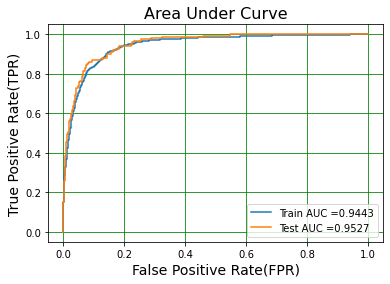

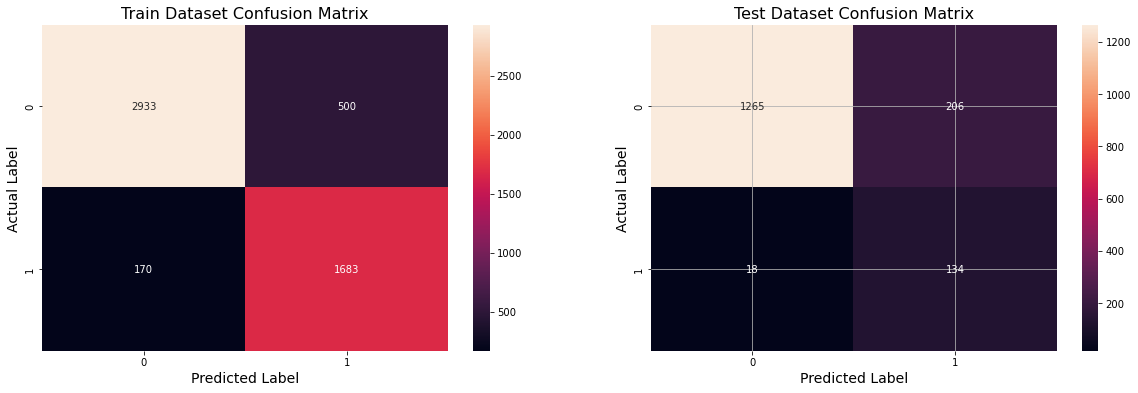

Best Threshold = 0.2105
Model AUC is : 0.9527
Model F1 Score is : 0.5447


In [42]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [43]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9614905580561607
Test AUC =  0.9263904790869083


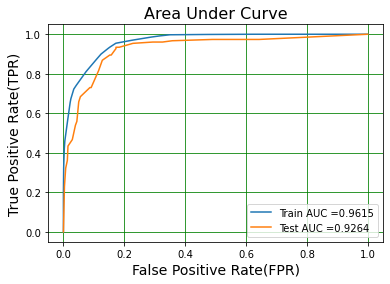

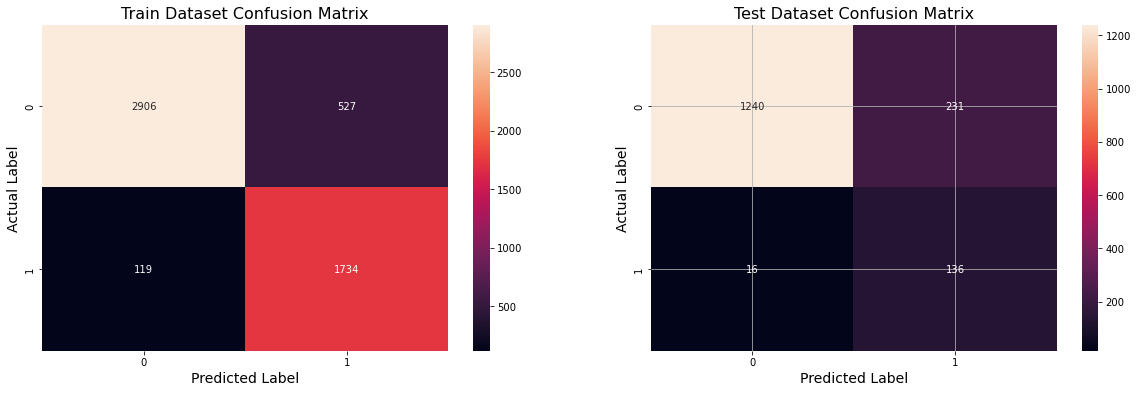

Best Threshold = 0.3750
Model AUC is : 0.9264
Model F1 Score is : 0.5241


In [44]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [45]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.954718566769407
Test AUC =  0.9428646820995384


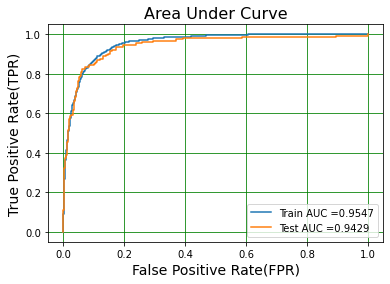

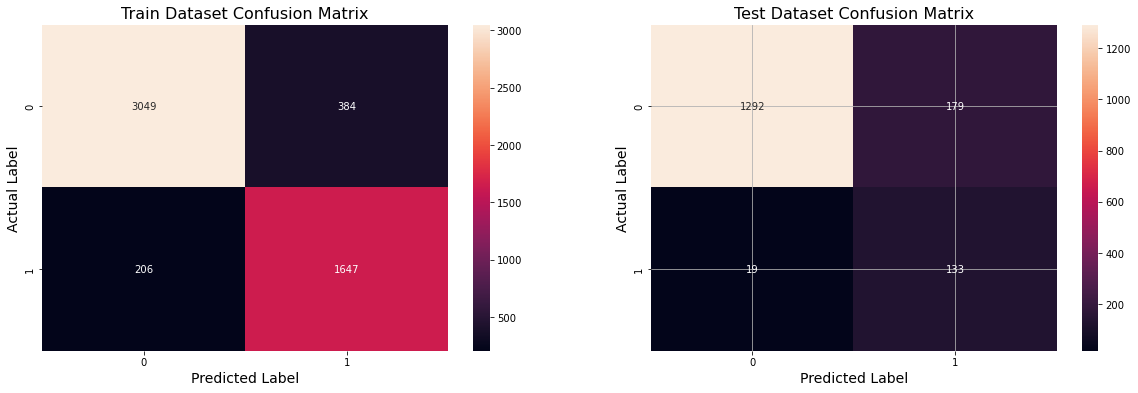

Best Threshold = 0.2665
Model AUC is : 0.9429
Model F1 Score is : 0.5733


In [46]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [47]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8514143776736663
Test AUC =  0.8810892160721314


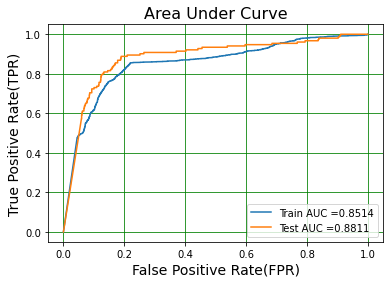

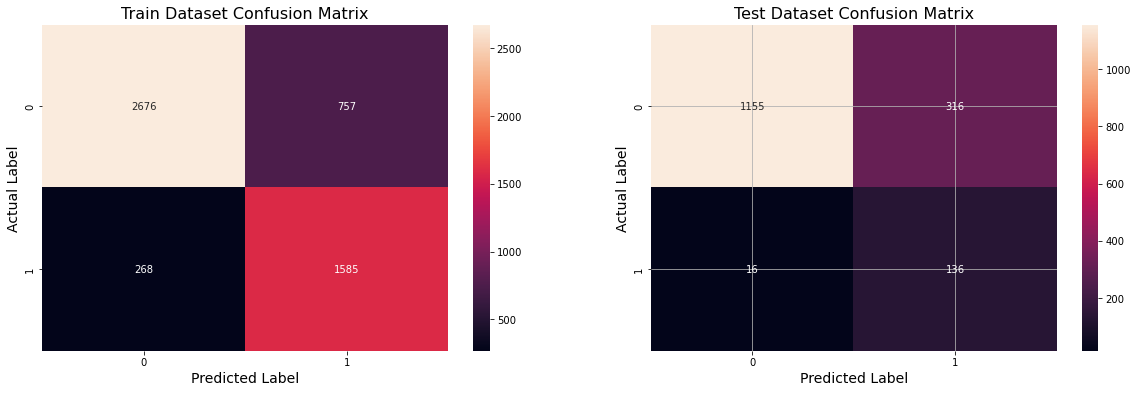

Best Threshold = 0.0000
Model AUC is : 0.8811
Model F1 Score is : 0.4503


In [48]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [49]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.53"])
table.append_row(["Decision Tree", "0.92", "0.55"])
table.append_row(["Support Vector Classifier", "0.94", "0.58"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.53   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.55   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.58   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best. For SVC and Decision tree F! score is higher than LR. Still I will consider LR as the best model because AUC is high for LR.

## Oversample the data using SMOTE to make it 50:50 ratio

In [50]:
oversample = SMOTE(sampling_strategy=1)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


### Train with LogisticRegression model

In [51]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

Train AUC =  0.9493397346516551
Test AUC =  0.9453245196608109


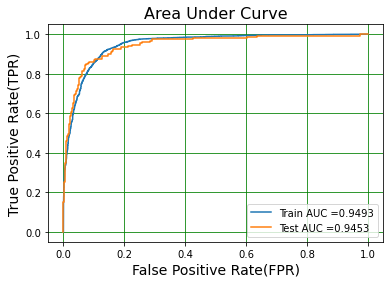

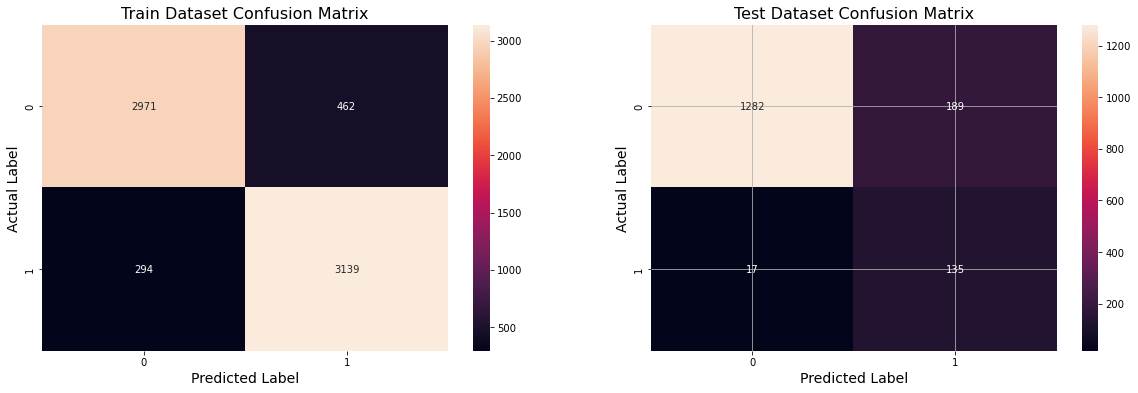

Best Threshold = 0.3318
Model AUC is : 0.9453
Model F1 Score is : 0.5672


In [52]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [53]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9684036020906727
Test AUC =  0.9128233568285091


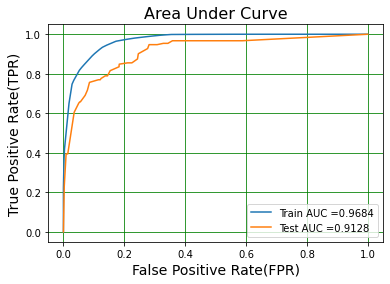

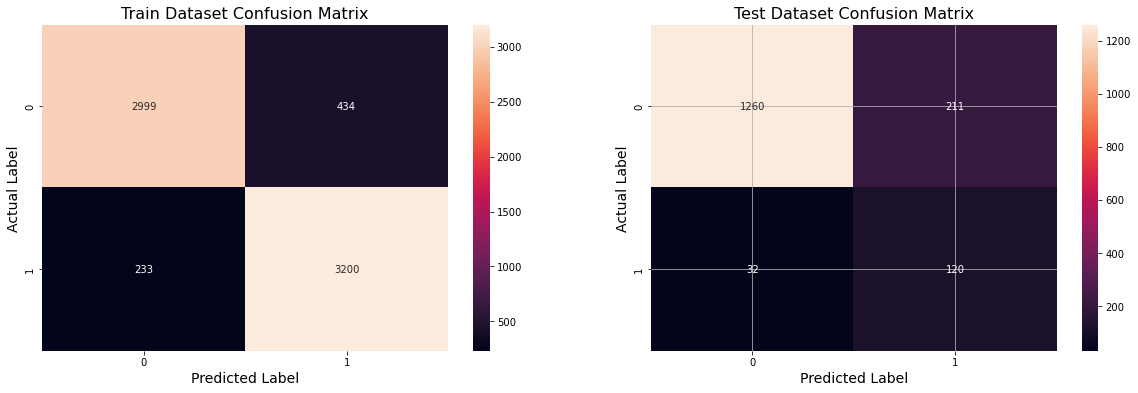

Best Threshold = 0.5424
Model AUC is : 0.9128
Model F1 Score is : 0.4969


In [54]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [55]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9558226222093967
Test AUC =  0.9405300726322946


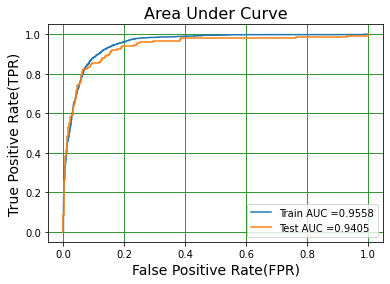

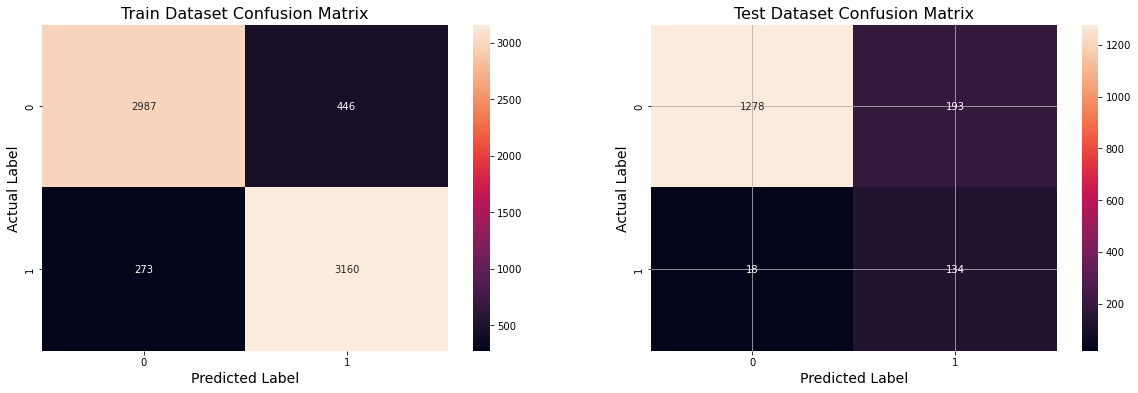

Best Threshold = 0.3587
Model AUC is : 0.9405
Model F1 Score is : 0.5595


In [56]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [57]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8501906878874521
Test AUC =  0.8813553257719418


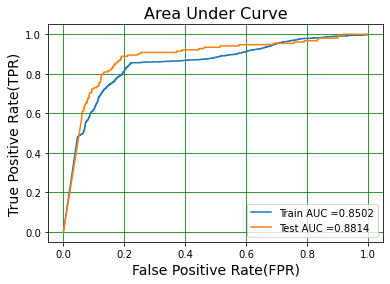

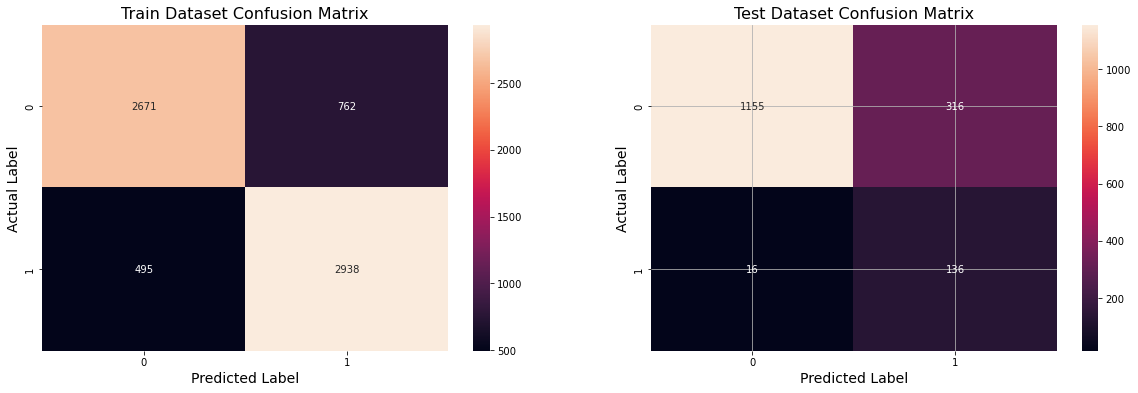

Best Threshold = 0.0000
Model AUC is : 0.8814
Model F1 Score is : 0.4503


In [58]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [59]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.94", "0.56"])
table.append_row(["Decision Tree", "0.91", "0.51"])
table.append_row(["Support Vector Classifier", "0.93", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.94 |   0.56   |
+---------------------------+------+----------+
|       Decision Tree       | 0.91 |   0.51   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.93 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
This time also after comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

### Overall observation accross all the sampling ratio.

In [60]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio", "Best Model", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Regression", "0.95", "0.55"])
table.append_row(["75:25", "Logistic Regression", "0.95", "0.54"])
table.append_row(["65:35", "Logistic Regression", "0.95", "0.53"])
table.append_row(["50:50", "Logistic Regression", "0.94", "0.56"])
print(table)

+----------------+---------------------+----------+----------+
| Sampling Ratio |     Best Model      |   AUC    | F1 Score |
+----------------+---------------------+----------+----------+
|     80:20      | Logistic Regression |   0.95   |   0.55   |
+----------------+---------------------+----------+----------+
|     75:25      | Logistic Regression |   0.95   |   0.54   |
+----------------+---------------------+----------+----------+
|     65:35      | Logistic Regression |   0.95   |   0.53   |
+----------------+---------------------+----------+----------+
|     50:50      | Logistic Regression |   0.94   |   0.56   |
+----------------+---------------------+----------+----------+


### Conclusion:
Logistic Regression is performing good accross all the sampling ratio. But if we look at both AUC and F1 score, the model with Sampling Ratio 80:20 is the best model for this problem.

<h2> Important Feature Selection Using Random Forest </h2>

In [61]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [62]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os, y_tr_os)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [63]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 20}
roc_auc_score : 0.9702705556495177


In [64]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os, y_tr_os)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9998190468624492
Test AUC =  0.9408051271959642


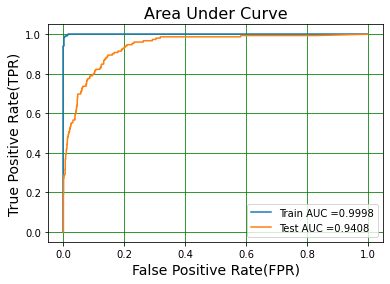

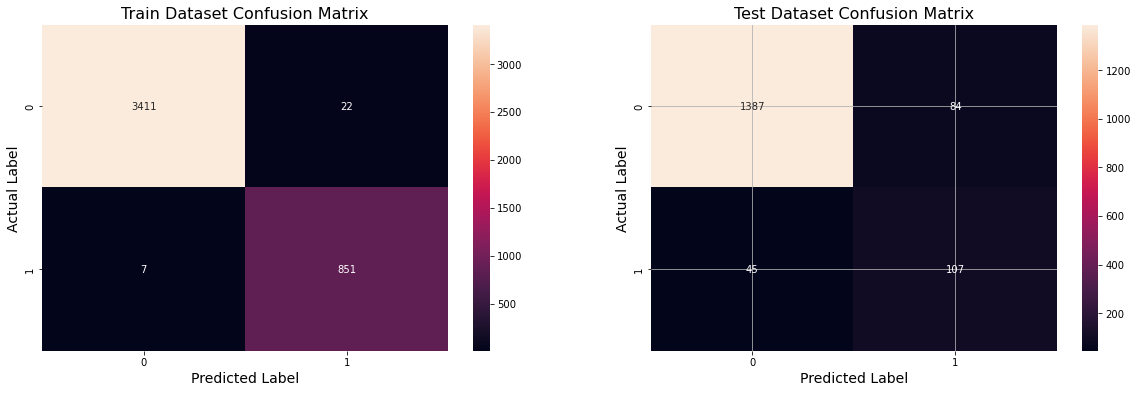

Best Threshold = 0.4266
Model AUC is : 0.9408
Model F1 Score is : 0.6239


In [65]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

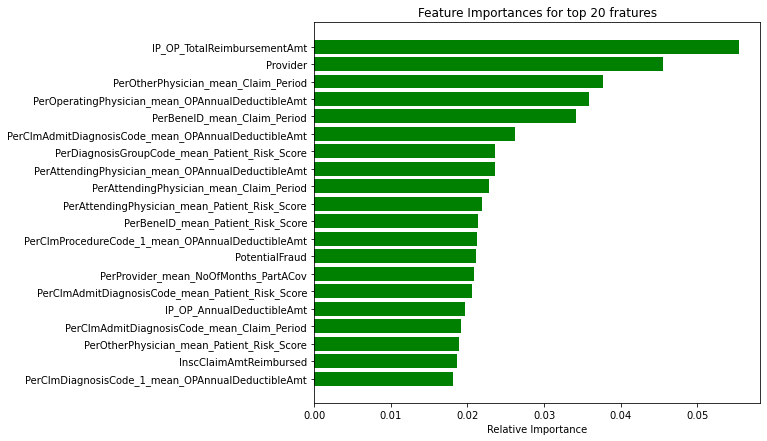

In [66]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot top 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
top_20_indices = imp_feature_indx[-20:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(top_20_indices)), importance_of_feature[top_20_indices], color='g', align='center')
plt.yticks(range(len(top_20_indices)), [features[i] for i in top_20_indices])
plt.xlabel('Relative Importance')
plt.show()

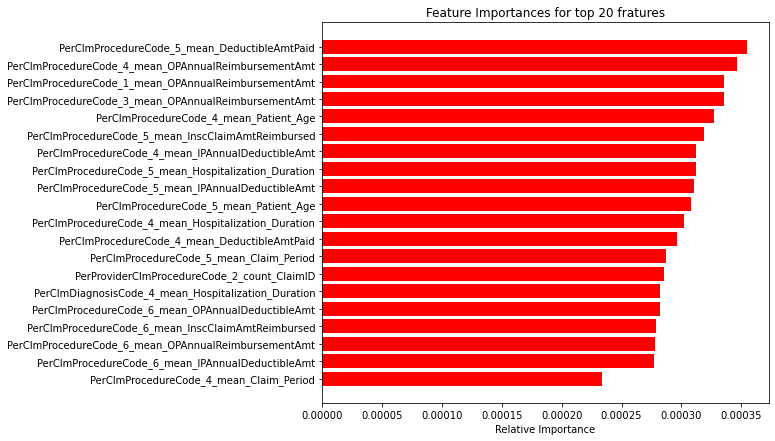

In [67]:
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
# Plot least important 20 features
features = Final_Dataset_Provider_Train.columns
importance_of_feature = random_forest.feature_importances_
imp_feature_indx = np.argsort(random_forest.feature_importances_)#[::-1]
# take_top_20 fratures
least_20_indices = imp_feature_indx[:20]
plt.figure(figsize=(8,7))
plt.title('Feature Importances for top 20 fratures')
plt.barh(range(len(least_20_indices)), importance_of_feature[least_20_indices], color='r', align='center')
plt.yticks(range(len(least_20_indices)), [features[i] for i in least_20_indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot the distribution of features with FE>0

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


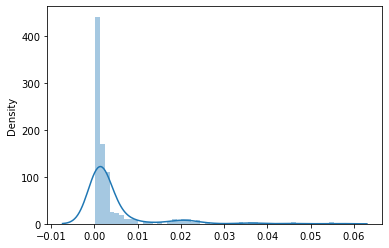

In [68]:
importance_of_feature = random_forest.feature_importances_
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0])
plt.show()

In [69]:
len(importance_of_feature[importance_of_feature>0])

246

#### plot the distribution of features with FE>0.001

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


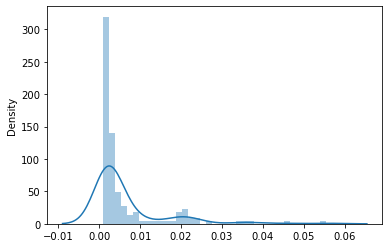

In [70]:
%matplotlib inline
sns.distplot(importance_of_feature[importance_of_feature>0.001])
plt.show()

In [71]:
len(importance_of_feature[importance_of_feature>0.001])

151

### Take top 161 features based on feature importance

In [72]:
# take all the feature columns in a list
features = list(x_train.columns)
imp_feature_indx = np.argsort(random_forest.feature_importances_)[::-1]
imp_value = np.take(random_forest.feature_importances_, imp_feature_indx[:161])
imp_feature_name = list(np.take(features, imp_feature_indx[:161]))

In [73]:
x_train_imp_features = x_train[imp_feature_name]
x_train_imp_features.shape

(5410, 161)

In [74]:
x_test_imp_features = x_test[imp_feature_name]
x_test_imp_features.shape

(1353, 161)

In [75]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train_imp_features)
x_train_if_std = standard_scaler.transform(x_train_imp_features)
x_test_if_std = standard_scaler.transform(x_test_imp_features)

In [76]:
# split the data into train and test
x_tr_if, x_val_if, y_tr_if, y_val_if = train_test_split(x_train_if_std, y_train, test_size=0.3,random_state=42,stratify=y_train)
x_tr_if.shape, x_val_if.shape, y_tr_if.shape, y_val_if.shape

((3787, 161), (1623, 161), (3787,), (1623,))

In [77]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os_if, y_tr_os_if = oversample.fit_resample(x_tr_if, y_tr_if)
counter = Counter(y_tr_os_if)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [78]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os_if, y_tr_os_if)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [79]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9391449595874258


In [80]:
log_reg = LogisticRegression(C=1.0, penalty='l2')
log_reg.fit(x_tr_os_if, y_tr_os_if)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Train AUC =  0.9461547288520781
Test AUC =  0.9384146123296002


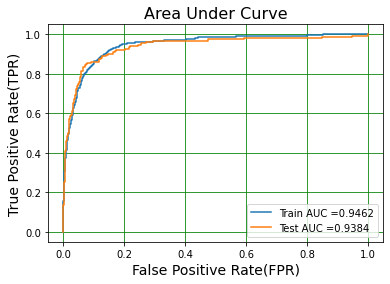

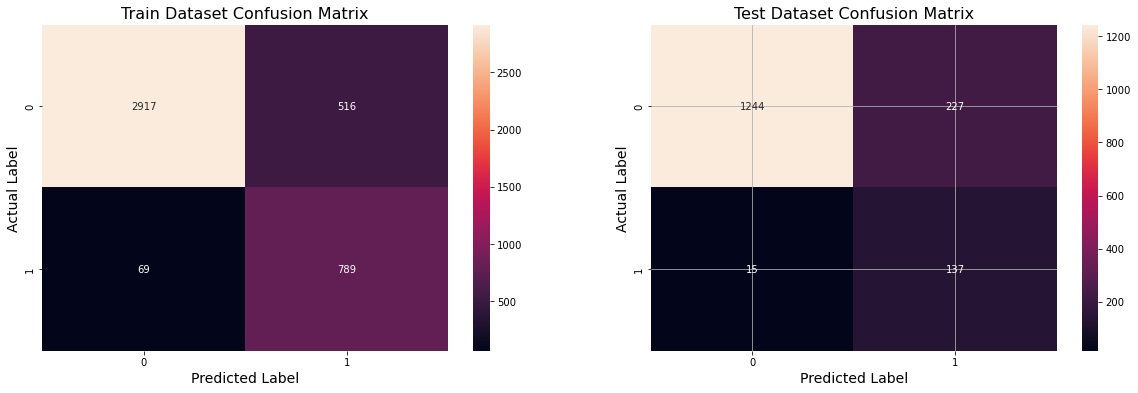

Best Threshold = 0.1115
Model AUC is : 0.9384
Model F1 Score is : 0.5310


In [81]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Now train Random Forest with important features

In [82]:
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_os_if, y_tr_os_if)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [83]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}
roc_auc_score : 0.9696845812649102


In [84]:
random_forest = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_features='auto', max_depth=20, random_state=42)
random_forest.fit(x_tr_os_if, y_tr_os_if)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       random_state=42)

Train AUC =  0.9997993559018901
Test AUC =  0.943128555583384


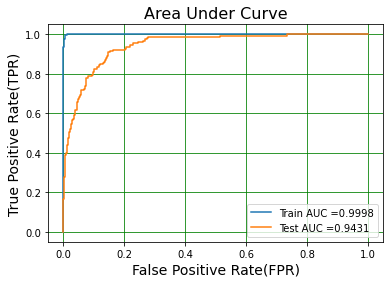

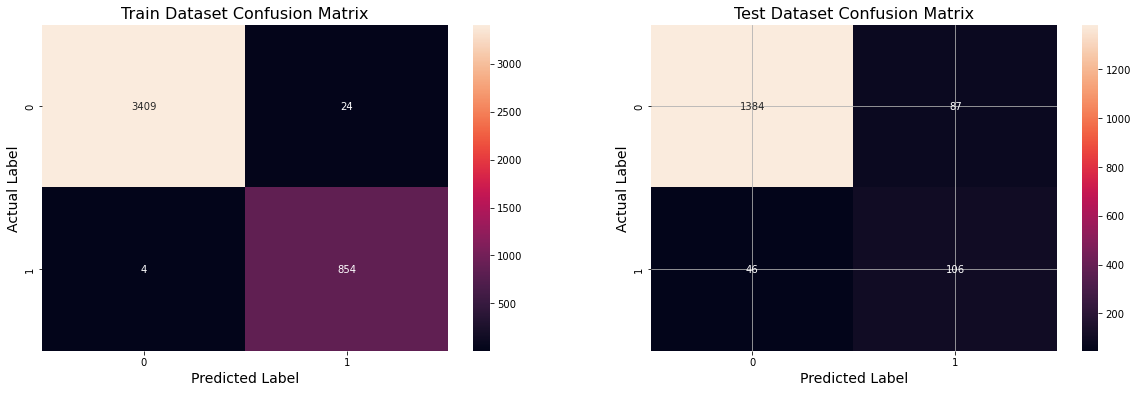

Best Threshold = 0.4151
Model AUC is : 0.9431
Model F1 Score is : 0.6145


In [85]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_os_if, x_val_if, y_tr_os_if, y_val_if)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [86]:
table = BeautifulTable() 
table.column_headers= ["Sampling Ratio     ", "      Model       ", "    Features          ", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Reg  ", "All Features","0.9508", "0.5513"])
table.append_row(["80:20", "Logistic Reg  ", "Important Features","0.9424", "0.5600"])
table.append_row(["80:20", "Random Forest ", "All Features","0.9431", "0.6203"])
table.append_row(["80:20", "Random Forest ", "Important Features","0.9429", "0.6343"])
print(table)

+-----------------+----------------+---------------------+----------+----------+
| Sampling Ratio  |       Model    |     Features        |   AUC    | F1 Score |
|                 |                |                     |          |          |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   |    All Features     |  0.951   |  0.551   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Logistic Reg   | Important Features  |  0.942   |   0.56   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  |    All Features     |  0.943   |   0.62   |
+-----------------+----------------+---------------------+----------+----------+
|      80:20      | Random Forest  | Important Features  |  0.943   |  0.634   |
+-----------------+----------------+---------------------+----------+----------+


## Final Comparison:

1. Logistic Regression vs Random Forest with all the features: Using RF, F1 score increased from LR model with little decrease in AUC. Aparently it can be said the RF model performing better than LR model. But if I look at the confusion matrix, False Negative(Predicted Not-Fraud but actually it is Fraud) count is more in RF, which is very dangerous in our case. After looking at all the scores it can be said that LR is performing better than RF.

2. After filtering the important features there is no such improvement in model performence for both LR and RF. F1 score is increased even though False negative also increased. In our case decreasing False Negative is more important than decreasing False Positive. So, I can say model is performing better with all features than only using top important features.

3. After considering AUC, F1 Score, FNR it can be said the Logistic Regression model is the best model in healthcare provider fraud detection problem.

In [87]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime/60))

Execution time in seconds: 906.9929704666138
Execution time in minutes: 15.116549507776897
